In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from cgmsquared import clustering as cgm2_cluster
from cgmsquared import clustering2 as c2
import haloclustering.evalulate_model as evaluate
import emcee
import corner
import pandas as pd
import scipy.special as sc
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
cosmology.setCosmology('planck15')
from colossus.halo import mass_so
import haloclustering.plot as hplt
import haloclustering.data as datamodule

from multiprocessing import Pool
from multiprocessing import cpu_count
import seaborn as sns

from scipy.stats import binned_statistic

plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16
from haloclustering import models
from astropy.stats import binned_binom_proportion

Deleted outdated persistence file, no further action needed.


In [3]:
# get data
df = pd.read_csv('../data/cgm2_casbah_velo_split_table_with_comoving_rho_and_mass.csv')
df['log_rho'] = np.log10(df.rho)
df.sort_values('rho', inplace=True)
# df.rho = df.rho / 1000 # convert to Mpc
df = df.query("(HM_0_500 != 'indeterminate') & (7 < mstars < 12)")
df['Hz'] = cosmo.H(df.z).value
vmax = 500.0 # km/s

df.dropna(subset=['mstars'], inplace=True)
massmask = df.eval("8 < mstars < 10.5").values
df['logm'] = df.mstars
df.mstars = 10**df.mstars


outcomes = df.HM_0_500.values
hits = (outcomes == "hit") & massmask
misses = (outcomes == "miss") & massmask


In [4]:
df.shape, 6701+543

((7244, 23), 7244)

In [5]:
df['survey'] = np.where(df.user == 'mwilde', r"CGM$^2$", r"CASBaH")

In [6]:
dfnew = df.copy()

# plot the summary of the data sets

<Figure size 720x504 with 0 Axes>

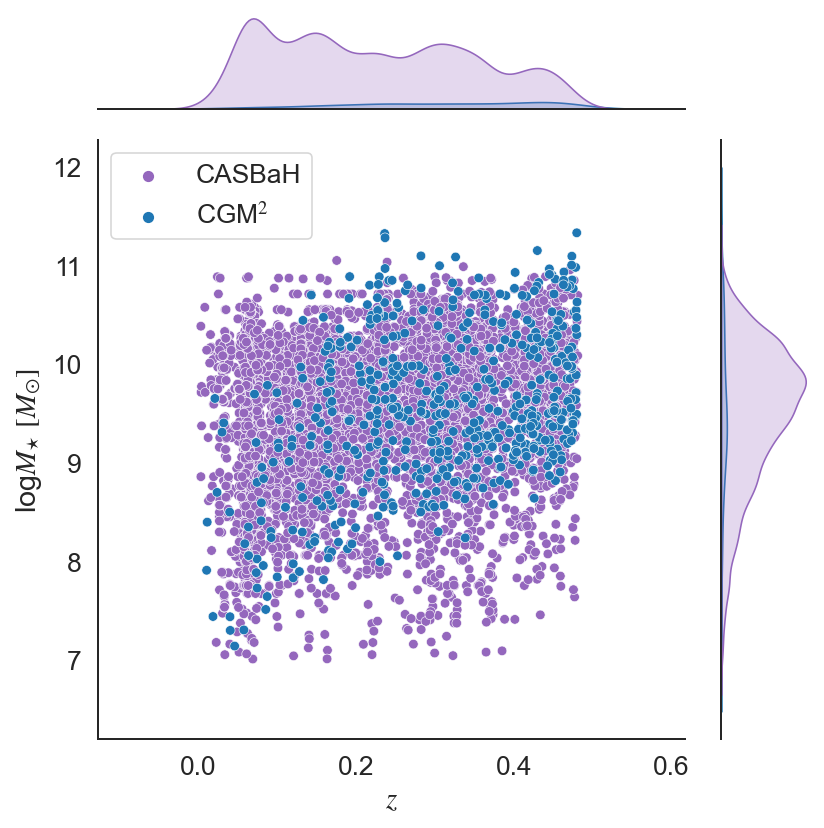

In [7]:
joint_kws=dict(gridsize=30)
plt.figure(figsize=(10,7))


# df.sort_values("survey", inplace=True)

dfnew.sort_values('survey', inplace=True)
sns.set_theme(style="ticks")
s = [r'$z$', r'log$M_{\star}$ $[M_{\odot}]$']
with sns.axes_style('white'):
    sns.set_context("paper", font_scale=1.5)

    g = sns.jointplot(data=dfnew, x="z", y="logm", hue='survey',
                    palette=["tab:purple", "tab:blue"],
                    legend=True, linewidth=0.3)

    g.set_axis_labels(s[0], s[1])
    # g.fig.get_axes()[0].legend([r'CGM$^2$', r'CASBaH'], loc='upper left')
    ax = g.fig.get_axes()[0]
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    plt.tight_layout()
    plt.savefig('../figures/combined_data_mass_z.pdf', dpi=300);

In [8]:
dfnew['rho_mpc'] = dfnew.rho / 1000
dfnew['log_rho_mpc'] = np.log10(dfnew.rho_mpc)

<Figure size 720x504 with 0 Axes>

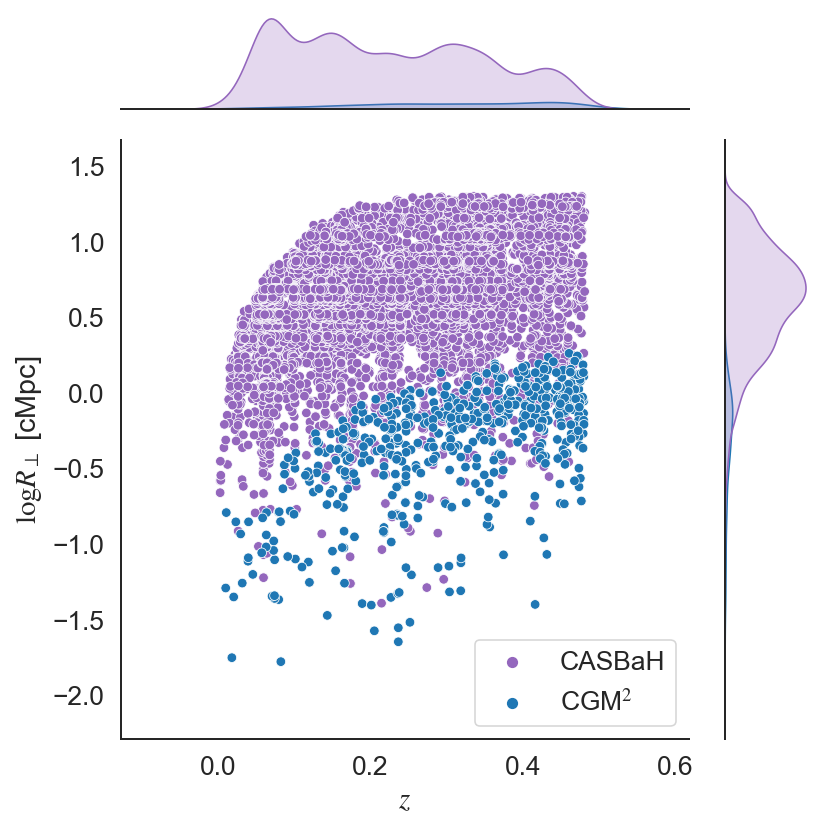

In [9]:
joint_kws=dict(gridsize=30)
plt.figure(figsize=(10,7))


# df.sort_values("survey", inplace=True)

dfnew.sort_values('survey', inplace=True)
sns.set_theme(style="ticks")
s = [r'$z$', r'$\log R_\perp $ [cMpc]']
with sns.axes_style('white'):
    sns.set_context("paper", font_scale=1.5)

    g = sns.jointplot(data=dfnew, x="z", y="log_rho_mpc", hue='survey',
                    palette=["tab:purple", "tab:blue"],
                    legend=True)

    g.set_axis_labels(s[0], s[1])
    # g.fig.get_axes()[0].legend([r'CGM$^2$', r'CASBaH'], loc='upper left')
    ax = g.fig.get_axes()[0]

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    plt.tight_layout()
    plt.savefig('../figures/combined_data_mass_rho.pdf', dpi=300);

<Figure size 720x504 with 0 Axes>

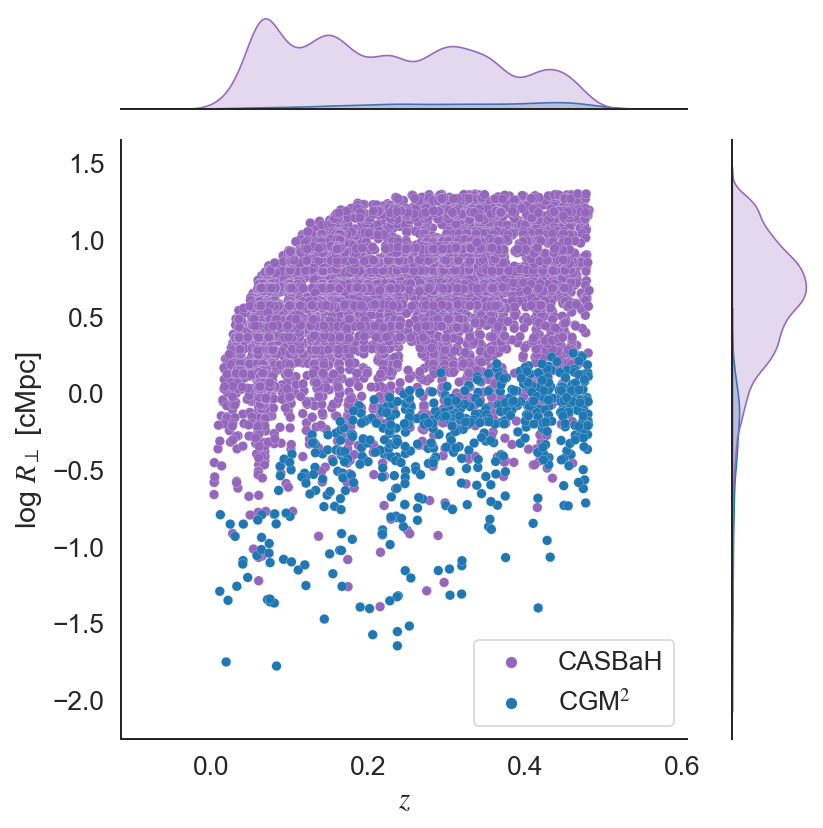

In [10]:
joint_kws=dict(gridsize=30)
plt.figure(figsize=(10,7))


# df.sort_values("survey", inplace=True)

dfnew.sort_values('survey', inplace=True)
sns.set_theme(style="ticks")
s = [r'$z$', r'log $R_\perp$ [cMpc]']
with sns.axes_style('white'):
    sns.set_context("paper", font_scale=1.5)

    g = sns.jointplot(data=dfnew, x="z", y="log_rho_mpc", hue='survey',
                    palette=["tab:purple", "tab:blue"],
                    legend=True, marginal_kws=dict(bw_adjust=0.9), linewidth=0.1)
    
    g.set_axis_labels(s[0], s[1])
    # g.fig.get_axes()[0].legend([r'CGM$^2$', r'CASBaH'], loc='upper left')
    ax = g.fig.get_axes()[0]

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    plt.tight_layout()
    # plt.xscale('log')
    # plt.yscale('log')
    plt.savefig('../figures/combined_data_z_rho_log.pdf', dpi=300);

# read in the covering fractions from the emcee samplers

In [11]:
def log_probability(params, rho_gal_com, z_gal, Hz, vmax, hits, misses, mass):
    r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff = params
    lp = log_prior(params)

    if not np.isfinite(lp):
        return -np.inf, np.full(mass.shape, np.nan)
    logl, prob_hit = log_likelihood(r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff, rho_gal_com, z_gal, Hz, vmax, mass, hits, misses)
    logprob = lp + logl
    return logprob, prob_hit

In [12]:
import pickle
pkl_file = '../exclusion-model/exclusion_model_gauss_1h_sampler.pkl'
infile = open(pkl_file, "rb")
sampler = pickle.load(infile)
infile.close()

pkl_file = '../exclusion-model/model_2h_w_beta_sampler.pkl'
infile = open(pkl_file, "rb")
sampler_2h = pickle.load(infile)
infile.close()

In [13]:
df.shape

(7244, 24)

In [14]:
df['cf_model'] = np.nanmean(sampler.blobs, axis=(0,1))
df['cf_model_2h'] = np.nanmean(sampler_2h.blobs, axis=(0,1))

1368
3816
1405


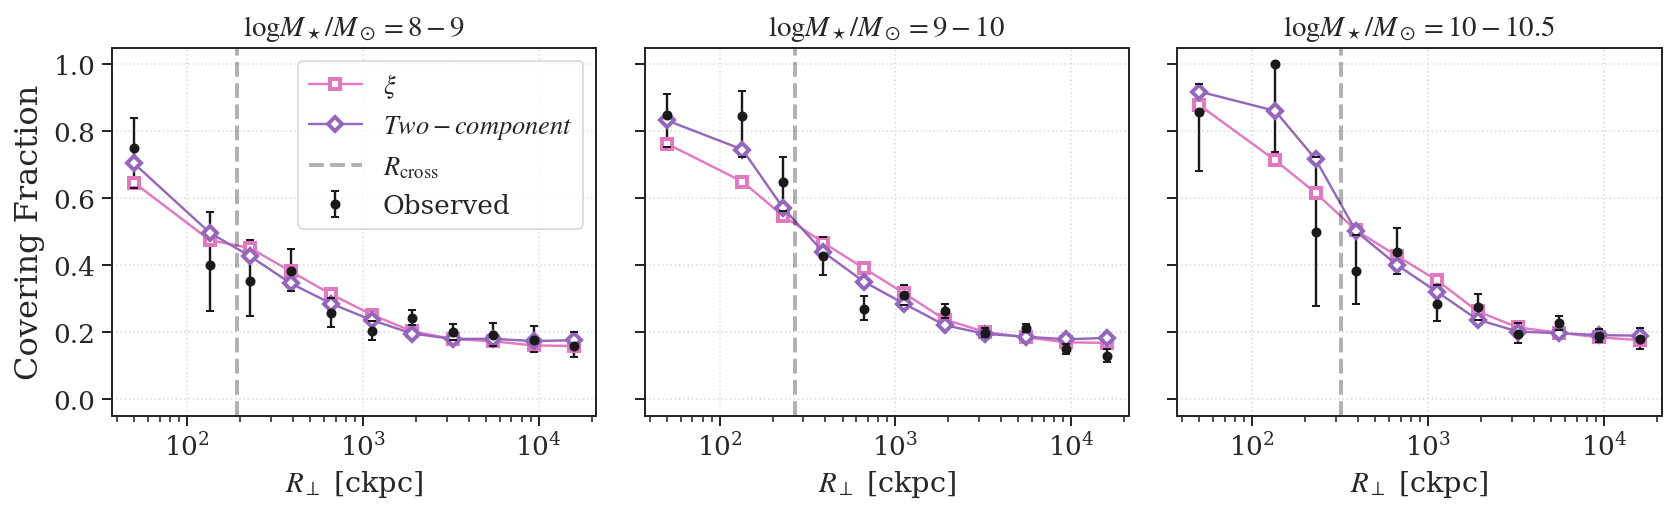

In [15]:
plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 18

#rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

rho_bins = np.concatenate([[0, 200], np.geomspace(400, 20e3, 6)])
rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

bin_ctr = 0.5*(rho_bins[1:] + rho_bins[:-1])
#rho_bins = np.geomspace(20, 20e3, 15)
#np.concatenate([[0, 100, 200], np.geomspace(300, 20e3, 7)])
# plt.close("all")

fig, axes = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

if False:
    rngs = [[7, 8], [8, 9], [9, 10], [10, 11]]
else:
    rngs = [[8, 9], [9, 10], [10, 10.5]]

rcs = [0.192,  0.26934, 0.3195] 


for e, (ax, rng, rc) in enumerate(zip(axes, rngs, rcs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    print(ssdf.__len__())
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
                                                 interval='jeffreys')

    # models
    model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    
    ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='tab:pink', mew=2, ls='-', c='tab:pink', label=r'$\xi$')
    ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='tab:purple', mew=2, ls='-', c='tab:purple', label=r'$Two-component$')

    # Rcross
    ax.axvline(rc*1e3, color='black', alpha=0.3, lw=2, ls='--', label=r'$R_{\rm cross}$')

    # data
    ax.errorbar(bin_ctr_p, p, yerr=perr, ls='none', marker='o', label='Observed'.format(*rng), capsize=2,
        color='k', markersize=4)
        
    ax.set_title(r'$\logM_\star/M_\odot = {}-{}$'.format(*rng))
    ax.set_xlabel(r"$R_{\perp}$ [ckpc]")
    ax.grid(ls=':', color='gainsboro')
axes[0].legend()
plt.xscale('log');

if False:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    plt.ylim(-0.05, 1.05)
# axes[1].set_xlabel('IP (ckpc)', fontsize=16)
axes[0].set_ylabel('Covering Fraction', fontsize=16);

plt.tight_layout();
plt.savefig('../figures/cf_plots_comparison.pdf', dpi=300)

In [16]:
# total galaxies used in 2 component model and 2 halo model
1368 + 3816 + 1405

6589

1368 & 3816 +& 1405

In [17]:
df7 = df.query(f'({8} < logm < {10.5})').copy()

In [18]:
df7

,Name,z,rho,ang_sep,RA,DEC,cosmo,CreationDate,user,HM_0_500,...,rvir,rho_rvir,gal_type,z_igmsys,log_rho,Hz,logm,survey,cf_model,cf_model_2h
0,J1553+3548_318_10,0.082712,16.619888,9.550870,238.268341,35.809929,Planck15,2021-Mar-15,mwilde,miss,...,130.879303,0.117270,SF,0.082555,1.220628,70.501571,8.841201,CGM$^2$,0.779171,0.872142
3,J1241+5721_200_6,0.205262,26.595202,6.350156,190.474000,57.350389,Planck15,2021-Mar-15,mwilde,hit,...,183.087643,0.117362,SF,0.205592,1.424803,75.189212,9.906535,CGM$^2$,0.894498,0.916569
5,J1016+4706_273_6,0.251955,30.293416,5.964228,154.091750,47.112139,Planck15,2021-Mar-15,mwilde,hit,...,183.168604,0.128978,SF,0.252365,1.481348,77.157643,9.960499,CGM$^2$,0.909457,0.917754
6,J1437+5045_0_11,0.143600,33.642968,11.304374,219.358948,50.768650,Planck15,2021-Mar-15,mwilde,hit,...,147.204612,0.199884,SF+E,0.143352,1.526894,72.742792,9.269478,CGM$^2$,0.827047,0.824539
8,J1342-0053_77_10,0.201268,39.367916,9.576648,205.717625,-0.895333,Planck15,2021-Mar-15,mwilde,miss,...,216.749748,0.149835,SF,0.201268,1.595142,75.025431,10.244928,CGM$^2$,0.909567,0.888109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7385,J1208+4540_32_2889,0.347793,19751.779597,2889.263486,182.859962,46.354607,Planck15,2021-Mar-28,jnburchett,miss,...,NaN,NaN,NaN,0.347793,4.295606,81.501861,9.389054,CASBaH,0.182219,0.164941
7386,J1208+4540_346_3109,0.321276,19772.743446,3109.054765,181.945907,46.515437,Planck15,2021-Mar-28,jnburchett,miss,...,NaN,NaN,NaN,0.321276,4.296067,80.259727,9.931272,CASBaH,0.176964,0.160875
7388,J0751+2919_56_3394,0.293134,19838.578641,3393.559141,118.704501,29.848535,Planck15,2021-Mar-09,jnburchett,miss,...,NaN,NaN,NaN,0.294790,4.297511,78.974832,8.304075,CASBaH,0.169481,0.151260
7390,J0751+2919_325_2204,0.477202,19961.539413,2203.667910,117.392278,29.825473,Planck15,2021-Mar-09,jnburchett,miss,...,NaN,NaN,NaN,0.475676,4.300194,87.987543,9.256881,CASBaH,0.211613,0.192601


In [19]:
ssdf.cf_model.values, model, ssdf.rho.values

(array([0.90956724, 0.9506636 , 0.90769869, ..., 0.20521513, 0.17826954,
        0.20382108]),
 BinnedStatisticResult(statistic=array([0.91880589, 0.8609598 , 0.71598107, 0.50057232, 0.40116564,
        0.31956772, 0.2366192 , 0.20098733, 0.1962494 , 0.19041789,
        0.1887211 ]), bin_edges=array([    0.        ,   100.        ,   169.86464646,   288.53998118,
          490.12741894,   832.5532074 ,  1414.21356237,  2402.24886796,
         4080.57154674,  6931.44843155, 11774.08037305, 20000.        ]), binnumber=array([ 1,  1,  1, ..., 11, 11, 11])),
 array([   39.36791634,    39.7618165 ,    40.28796318, ...,
        19615.82223371, 19681.0998996 , 19710.92007772]))

# combnined corner plot

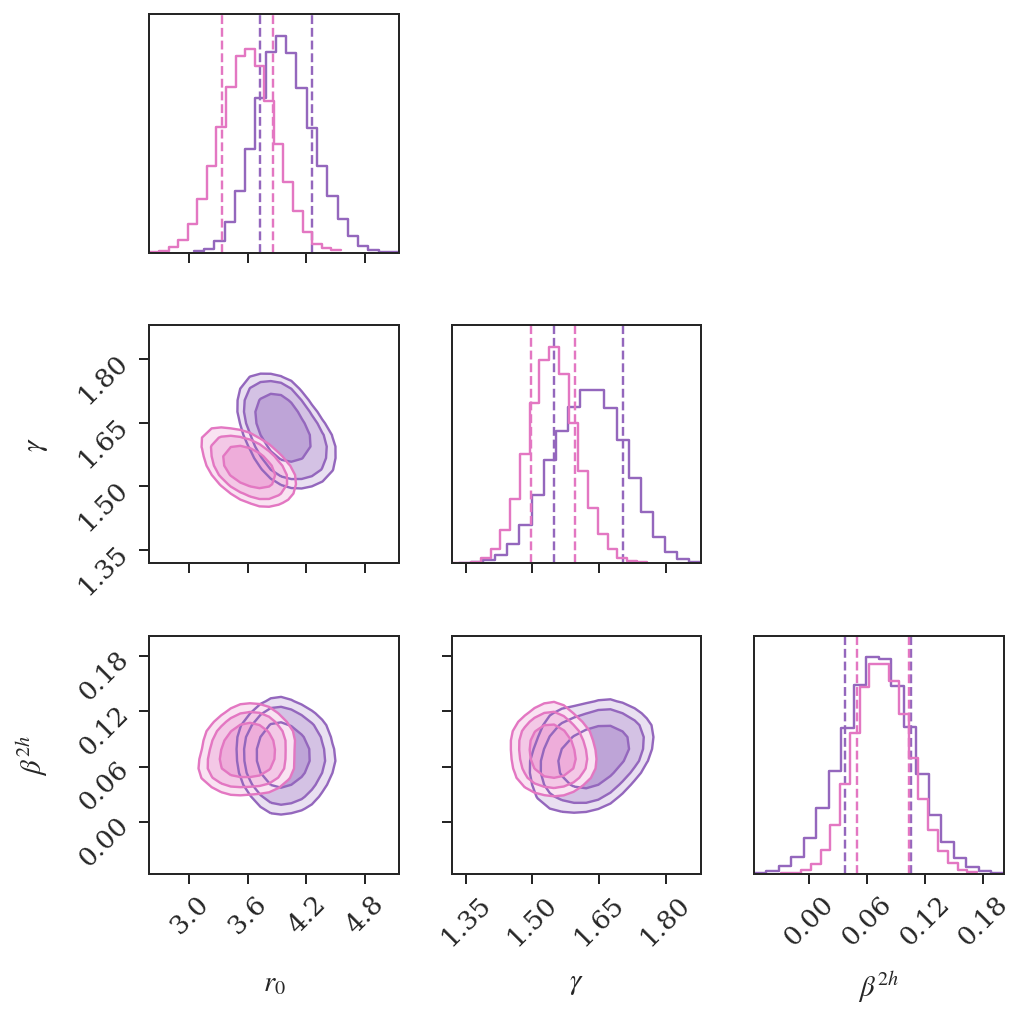

In [20]:
flat1 = sampler.get_chain(discard=2125, thin=1, flat=True)
flat2 = sampler_2h.get_chain(discard=2000, thin=1, flat=True)
levels = (0, 1-np.exp(-0.5), 1-np.exp(-1), 1-np.exp(-1.5))
labels2 = [r"$r_{0}$", r"$\gamma$", r"$\beta^{2h}$", r"$\alpha$", r'$C_0$']
labels1 = [r"$r_{0}$", r"$\gamma$", r"$\beta^{2h}$", r"$A$", r"$R_{\rm cross}$", r"$\beta^{1h}$", r"$\alpha$", r'$C_0$']
weights1=np.ones(len(flat1))/len(flat1)
weights2=np.ones(len(flat2))/len(flat2)
fig = corner.corner(
    flat1[:, :3], labels=labels1, levels=levels, quantiles=[0.16, 0.84], show_titles=False, title_kwargs={"fontsize": 16}, 
    smooth=1, smooth1d=1, labelpad=0.1, plot_datapoints=False, plot_density=False,
    fill_contours=True, weights=weights1, color="tab:purple"
);
corner.corner(flat2[:, :3], labels=labels2, levels=levels, quantiles=[0.16, 0.84], show_titles=False, title_kwargs={"fontsize": 16}, 
    smooth=1, smooth1d=1, labelpad=0.1, plot_datapoints=False, plot_density=False,
    fill_contours=True, weights=weights2, color="tab:pink",fig=fig)
plt.tight_layout()
plt.savefig('../figures/corner_comparison.png', dpi=300)

In [21]:
flat1 = sampler.get_chain(discard=2125, thin=1, flat=True)
flat2 = sampler_2h.get_chain(discard=1000, thin=1, flat=True)
flat1.shape, flat2.shape, weights1.shape

((30000, 8), (30000, 5), (30000,))

# Galaxy bias

In [22]:
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import peaks
cosmology.setCosmology('planck15')

In [23]:
mhalo = np.geomspace(1e10, 1e12, 100) # Msun/h
z = 0.3
b = bias.haloBias(mhalo, model = 'tinker10', z = z, mdef = '200m')

In [24]:
df.columns

Index(['Name', 'z', 'rho', 'ang_sep', 'RA', 'DEC', 'cosmo', 'CreationDate',
       'user', 'HM_0_500', 'HM_0_100', 'HM_100_200', 'HM_200_300',
       'HM_300_400', 'HM_400_500', 'mstars', 'rvir', 'rho_rvir', 'gal_type',
       'z_igmsys', 'log_rho', 'Hz', 'logm', 'survey', 'cf_model',
       'cf_model_2h'],
      dtype='object')

In [25]:
import casbah.gal_properties as caprop
upperm = 10**10.5
sdf = df.query('1e8 < mstars < @upperm')
mstars = np.log10(sdf.mstars.values)
redshift = sdf.z.values
logmhalo = np.array([caprop.calchalomass(m, z) for m, z in zip(mstars, redshift)])

Text(0, 0.5, 'Bias')

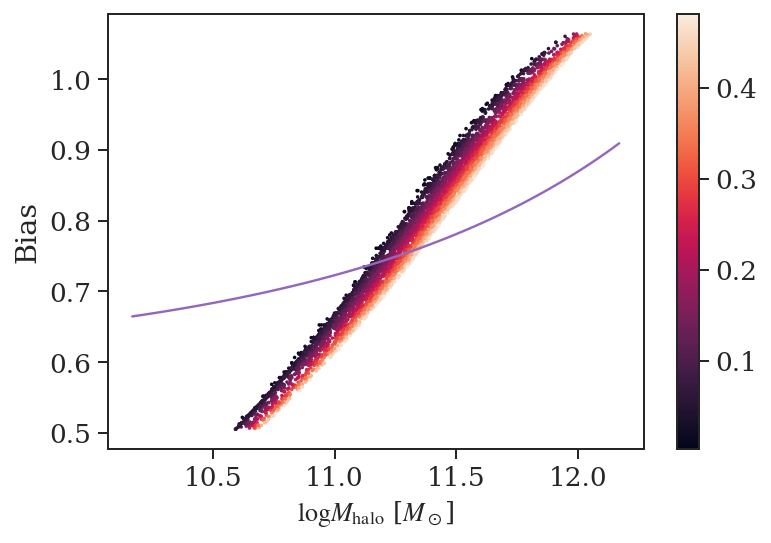

In [26]:
gamma = 1.62
beta2h = 0.08
predicted_bias = (10**(mstars - 9.5))**(gamma*beta2h)
plt.scatter(logmhalo, predicted_bias*0.79, s=1, c=redshift)
plt.colorbar()
plt.plot(np.log10(mhalo/cosmo.h), b, color='tab:purple', label='Tinker10')
plt.xlabel('$\logM_{\mathrm{halo}}$ [$M_\odot$]', fontsize=13);
plt.ylabel('Bias')

# Splashback Radius

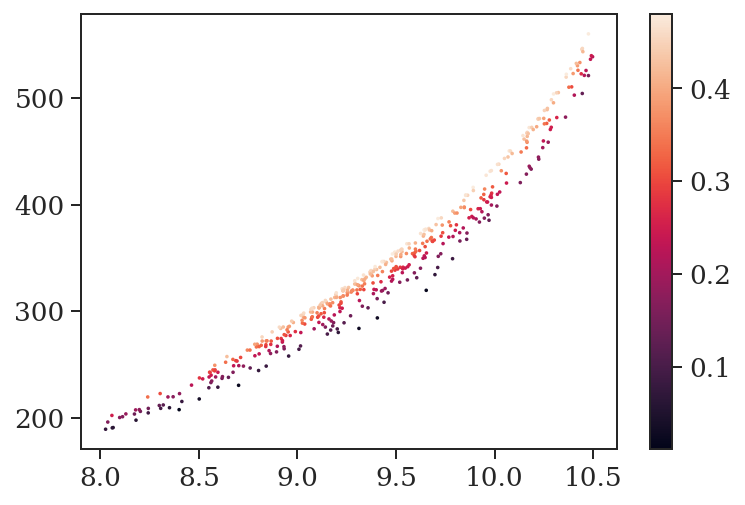

In [27]:
from colossus.lss import peaks
from colossus.halo import splashback

upperm = 10**10.5
sdf = df.query('1e8 < mstars < @upperm')
mstars = np.log10(sdf.mstars.values)
redshift = sdf.z.values
logmhalo = np.array([caprop.calchalomass(m, z) for m, z in zip(mstars, redshift)])
M200m = 10**logmhalo # already M200m not c i think
z = sdf.z
nu200m = peaks.peakHeight(M200m, z)
RspR200m, mask = splashback.splashbackModel('RspR200m', nu200m = nu200m, z = z, rspdef='sp-apr-mn')

plt.scatter(mstars, RspR200m*sdf.rvir*(1+z)/cosmo.h, s=1, c=z)
plt.colorbar()


In [28]:
from colossus.lss import peaks
from colossus.halo import splashback
from astropy.cosmology import Planck15 as cosmo

M200m = 1e12 # Msun/h
z = 0.5
nu200m = peaks.peakHeight(M200m, z)
RspR200m, mask = splashback.splashbackModel('RspR200m', nu200m = nu200m, z = z, rspdef='sp-apr-mn')

In [29]:
RspR200m/cosmo.h

1.747322738966603

In [30]:
import casbah.gal_properties as caprop
def calc_rvir(mass_space, redshift):
    """caclulate the virial radius of a halo in a given logmstar array and redshift

    Args:
        mass_space (_type_): _description_
        redshift (_type_): _description_

    Returns:
        _type_: _description_
    """
    logmhalo = [
            caprop.calchalomass(logmstar, redshift)
            for logmstar in mass_space]
    rvir = np.array([caprop.calcrvir(mh, redshift) for mh in logmhalo])
    return rvir

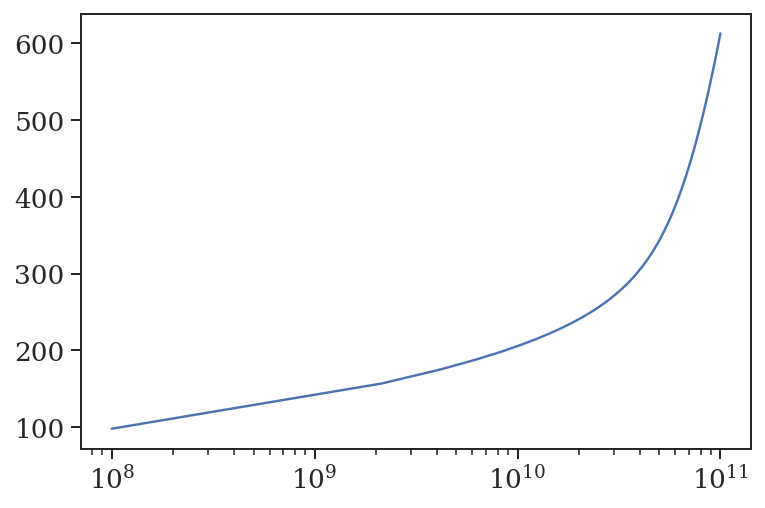

In [31]:
from colossus.lss import peaks
from colossus.halo import splashback


def calc_splashback(mstar_arr, redshift, comoving=False):
    """calculate the splashback radius of a halo in a given linear mstar array and single redshift. 
    returns the splashback radius in comoving kpc.
    """
    M200c = 10**np.array([caprop.calchalomass(m, redshift) for m in np.log10(mstar_arr)])
    
    # calculate the peak hieghts at each mass, M200m needs to be linear
    nu200c = peaks.peakHeight(M200c, redshift)

    # calculate the splashback radius in units of R200m/h
    RspR200c, mask = splashback.splashbackModel('RspR200m', nu200m=nu200m, z=redshift, rspdef='sp-apr-mn')

    # calculate Rvir to convert to kpc
    # rvir - the correct 200c virial radius via colossus in comoving kpc. take care of h
    R200c= mass_so.M_to_R(M200c*cosmo.h, redshift, '200c')/cosmo.h # proper kpc

    # convert to comoving kpc
    r_splash = (RspR200c)*(1+redshift)*R200c 

    return r_splash

Mstar200m = np.linspace(1e8, 1e11)
meanz = np.mean(sdf.z)
redshift = meanz
r_splash = calc_splashback(Mstar200m, redshift)
plt.plot(Mstar200m, r_splash)
plt.xscale('log')

In [32]:

from colossus import halo
redshift = 0.25
mstars = np.linspace(1e8, 1e11)
logmhalo = np.array([caprop.calchalomass(mstar, redshift) for mstar in np.log10(mstars)]) # Moster+13 log M200c
rvir = np.array([caprop.calcrvir(mh, redshift) for mh in logmhalo]) # proper kpc

In [33]:
# np.argmin(np.abs(logmhalo - 11.5))
np.searchsorted(logmhalo, 11.5), np.log10(mstars)[3]

(3, 9.79353381897151)

In [34]:
caprop.calchalomass(8, 0.3), caprop.calchalomass(10.5, 0.3), caprop.calchalomass(10.5, 0.3)

(10.661074176913024, 12.016312333519643, 12.016312333519643)

Deleted outdated persistence file, no further action needed.
Deleted outdated persistence file, no further action needed.


Text(0, 0.5, 'R200c')

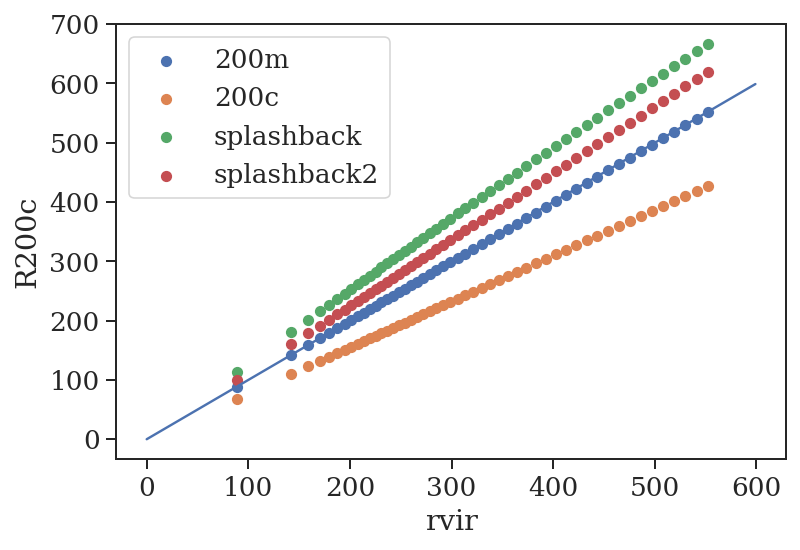

In [35]:
cosmology.setCosmology('planck15')
from colossus import halo
from numpy import common_type
R200m = mass_so.M_to_R((10**logmhalo)*cosmo.h, redshift, '200m')/cosmo.h # proper kpc?
R200c = mass_so.M_to_R((10**logmhalo)*cosmo.h, redshift, '200c')/cosmo.h # proper kpc?
Rsp, Msp, _ = halo.splashback.splashbackRadius(redshift, mdef='200c', R=R200c*cosmo.h,
            model='diemer20', statistic='median', rspdef='sp-apr-mn', 
            c_model='diemer19', profile='nfw') # Rsplash proper kpc / h

# get rid of little h and make comoving
Rsp_h = Rsp/cosmo.h
# Rsp_h = Rsp_h*(1+redshift)

rsp = calc_splashback(mstars, redshift, comoving=False)
plt.scatter(rvir, R200m, label='200m')
plt.scatter(rvir, R200c, label='200c')
plt.scatter(rvir, Rsp_h, label='splashback')
plt.scatter(rvir, rsp, label='splashback2')
plt.legend()
plt.plot(np.arange(0,600), np.arange(0,600))
plt.xlabel('rvir')
plt.ylabel('R200c')

In [36]:
def calc_splashback(mstars, redshift, comoving=True):
    logmhalo = np.array([caprop.calchalomass(mstar, redshift) for mstar in np.log10(mstars)]) # Moster+13 log M200c
    R200c = mass_so.M_to_R((10**logmhalo)*cosmo.h, redshift, '200c')/cosmo.h # proper kpc?
    Rsp, Msp, _ = halo.splashback.splashbackRadius(redshift, mdef='200c', R=(R200c*cosmo.h),
            model='diemer20', statistic='median', rspdef='sp-apr-mn', 
            c_model='diemer19', profile='nfw') # Rsplash proper kpc / h

    Rsp = Rsp / cosmo.h
    if comoving:
        Rsp = Rsp*(1+redshift)
    return Rsp

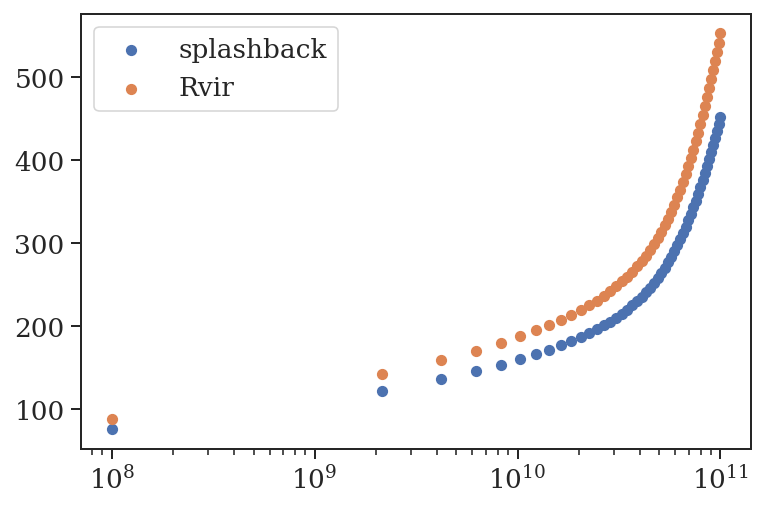

In [37]:
rsp = calc_splashback(mstars, redshift, comoving=False)
plt.scatter(mstars, Rsp, label='splashback')
plt.scatter(mstars, rvir, label='Rvir')
plt.legend()
plt.xscale('log')

# $R_{cross}$ plot with R50

In [38]:
def anti_derivative_full(r0, gamma, r_parallel, r_perpendicular):
    """
    This is the analytic solution to the integrand.

    see the solution at https://www.wolframalpha.com/input/?i=integral+%28sqrt%28x%5E2+%2B+r%5E2%29%2Fr0%29%5E-g


    Args:
        r0: scale length in comoving Mpc
        gamma: power law term.
        r_parallel: the integrand
        r_perpendicular: the rho_comoving_mpc measurements from the galaxies

    Returns:
        full: the anti-derivative

    """
    x = r_parallel
    r = r_perpendicular
    g = gamma
    full = (
        (x * (np.sqrt(r ** 2 + x ** 2) / r0) ** (-g))
        * (1 + x ** 2 / r ** 2) ** (g / 2)
        * sc.hyp2f1(1 / 2, g / 2, 3 / 2, -(x ** 2) / r ** 2)
    )
    return full

def integral_1h(rho, A, sigma, s_eval):
    part1 = np.sqrt(np.pi/2) * sigma * np.exp(-rho**2/(2*sigma**2))
    part2 = sc.erf(s_eval/(np.sqrt(2)*sigma))
    return A * part1 * part2

def integral_2h(rho, s_max, s_eval, r0, gamma):
    part1 = anti_derivative_full(r0, gamma, s_max, rho) # Mpc
    part2 = anti_derivative_full(r0, gamma, s_eval, rho) # Mpc
    return part1 - part2

def chi_perp(r0, gamma, A, sigma, r_cross, rho_gal_com, z_gal, Hz, vmax):
    dv = vmax  # km/s
    a = 1 / (1 + z_gal)
    norm_const = a * Hz / (2 * dv)  # 1/Mpc
    s_max = dv / (a * Hz)  # Mpc
    s_cross = np.sqrt(np.maximum(r_cross**2 - rho_gal_com**2, 0))
    s_eval = np.minimum(s_max, s_cross) 
    integrand = integral_1h(rho_gal_com, A, sigma, s_eval) + integral_2h(rho_gal_com, s_max, s_eval, r0, gamma)
    chi = norm_const * integrand
    return chi

def chi_perp_2h(r0, gamma, rho_gal_com, z_gal, Hz, vmax):
    """compute the integral of the clustering function along the line of site. 
    Use the analytic solution. works for either a single valued r0, gamma or broadcasts
    correctly with r0 ~ Rvir of each galaxy. 

    Args:
        r0 (float, ndarray): scaling factor for the clustering power law. can be a float or an array
            with length matching that of the number of galaxies.
        gamma (float): clustering power law index. 

    Returns:
        ndarray: chi_perp array with length equal to number of galaxies.
    """
    chi_i = c2.chi_perp_analytic(r0, gamma, rho_gal_com, z_gal, Hz, vmax)
    return chi_i

def _choose_rc(rc, A, r0, gamma):
    """ Choose which crossing to use.

    Args:
        rc (_type_): _description_
        A (_type_): _description_
        r0 (_type_): _description_
        gamma (_type_): _description_

    Returns:
        _type_: _description_
    """
    deriv = 2*np.log(A) + gamma*(2*np.log(rc/r0) - 1)
    if np.all(deriv > 0):
        return rc
    else:
        return None

def _calc_sig(rc, A, r0, gamma):
    r = _choose_rc(rc, A, r0, gamma)
    if r is None:
        return None
    else:
        sig = 0.5*r**2 / (np.log(A) + gamma*(np.log(r/r0)))
        return np.sqrt(sig)

def mean_dNdz(z, dndz_index, dndz_coeff, vmax=500.0):
    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(
        z, danforth=False, gamma=dndz_index, coeff=dndz_coeff
    )
    clight = 299792.458
    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3
    return mean_dN_dz

def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross

def r0_beta(r0, beta2h, mass, m0= 10**9.5):
    r0 = r0*(mass/m0) ** beta2h
    return r0

def phit(params, rho_gal_com, z_gal, Hz, vmax, mass):
    r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff = params
    r_cross = r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5)
    r0 = r0_beta(r0, beta2h, mass, m0= 10**9.5)
    sigma = _calc_sig(r_cross, A, r0, gamma)
    if sigma is None:
        return None
    chi = chi_perp(r0, gamma, A, sigma, r_cross, rho_gal_com, z_gal, Hz, vmax)
    dndz = mean_dNdz(z_gal, dndz_index, dndz_coeff)
    phit = 1 - np.exp(-(1 + chi)*dndz)
    phit = np.clip(phit, 0.00001, 0.99)
    return phit

def phit_2h(params, rho_gal_com, z_gal, Hz, vmax, mass):
    r0, gamma, beta2h, dndz_index, dndz_coeff = params
    r0 = r0_beta(r0, beta2h, mass, m0= 10**9.5)
    chi = chi_perp_2h(r0, gamma, rho_gal_com, z_gal, Hz, vmax)
    dndz = mean_dNdz(z_gal, dndz_index, dndz_coeff)
    phit = 1 - np.exp(-(1 + chi)*dndz)
    phit = np.clip(phit, 0.00001, 0.99)
    return phit

def r50(fc_list, r_lin):
    r50_idx = np.array([np.argmin(np.abs(fc - 0.5)) for fc in fc_list], dtype="int")
    r50 = r_lin[r50_idx]
    return r50*1e3

def r50_qantiles(fc_list, r_lin):
    fc_lo, fc_med, fc_hi = np.quantile(fc_list, [0.16, 0.5, 0.84], axis=2)

    r50_lo = r50(fc_lo, r_lin)
    r50_med = r50(fc_med, r_lin)
    r50_hi = r50(fc_hi, r_lin)

    return r50_lo, r50_med, r50_hi

# get the parameter distributions and define r,z,m lines and get fc for the fits

In [39]:
# meandraw = np.nanmean(flat_samples, axis=0)
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
flat_samples2h = sampler_2h.get_chain(discard=2000, thin=1, flat=True)
r_lin = np.geomspace(0.001, 20, 1000)[:,None]
z_lin = np.mean(sdf.z_igmsys.values)
hz_lin = cosmo.H(z_lin).value
m_lin = np.geomspace(1e7, 10**11.5, 20)[:, None]
# calc phit given random sampling from posteriors, calcluated a r, z... from lines
fc_list = [phit(flat_samples[::20].T, r_lin, z_lin, hz_lin, 500.0, m) for m in m_lin]
fc_arr = np.array(fc_list, dtype=object)
fc_list2h = [phit_2h(flat_samples2h[::20].T, r_lin, z_lin, hz_lin, 500.0, m) for m in m_lin]


### plot the distribution of shapes over the mass ranges

/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


AxisError: axis 2 is out of bounds for array of dimension 1

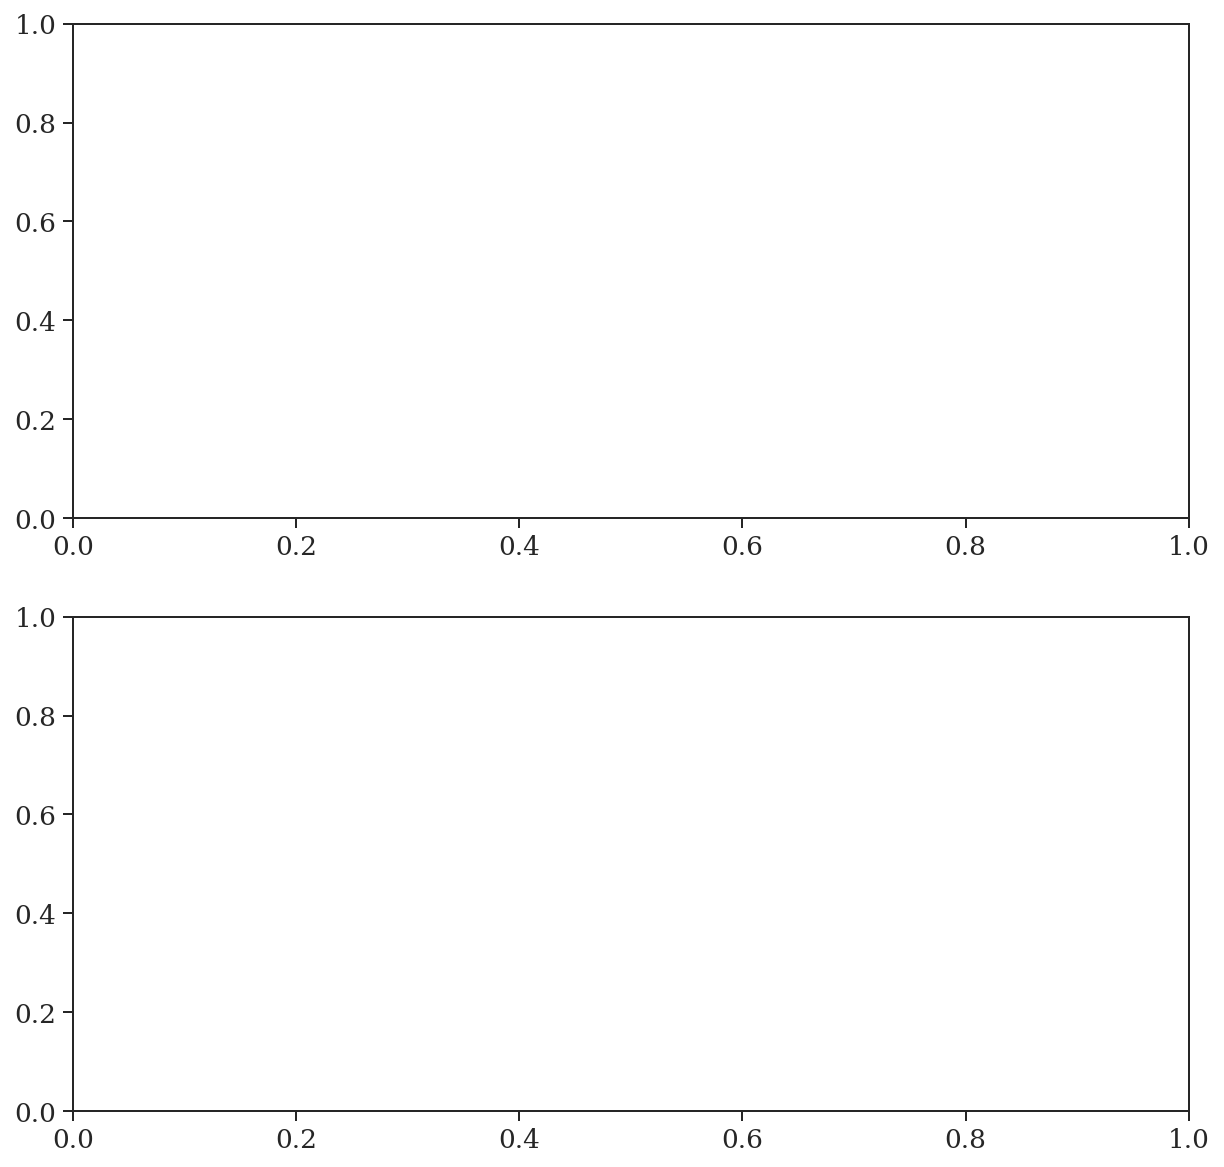

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for ax, fc in zip(axes, [fc_list, fc_list2h]):
    # print(fc.shape)
    ax.plot(r_lin, np.mean(fc, axis=2).T)
    ax.set_xscale('log')
    ax.set_yscale('log')

In [ ]:
# calculate the medians of r50
r50_lo2h, r50_med2h, r50_hi2h = r50_qantiles(fc_list2h, r_lin)
r50_lo, r50_med, r50_hi = r50_qantiles(fc_list, r_lin)

NameError: name 'r50_qantiles' is not defined

In [ ]:
plt.plot(np.log10(m_lin) , r50_med)
plt.plot(np.log10(m_lin) , r50_med2h)

NameError: name 'm_lin' is not defined

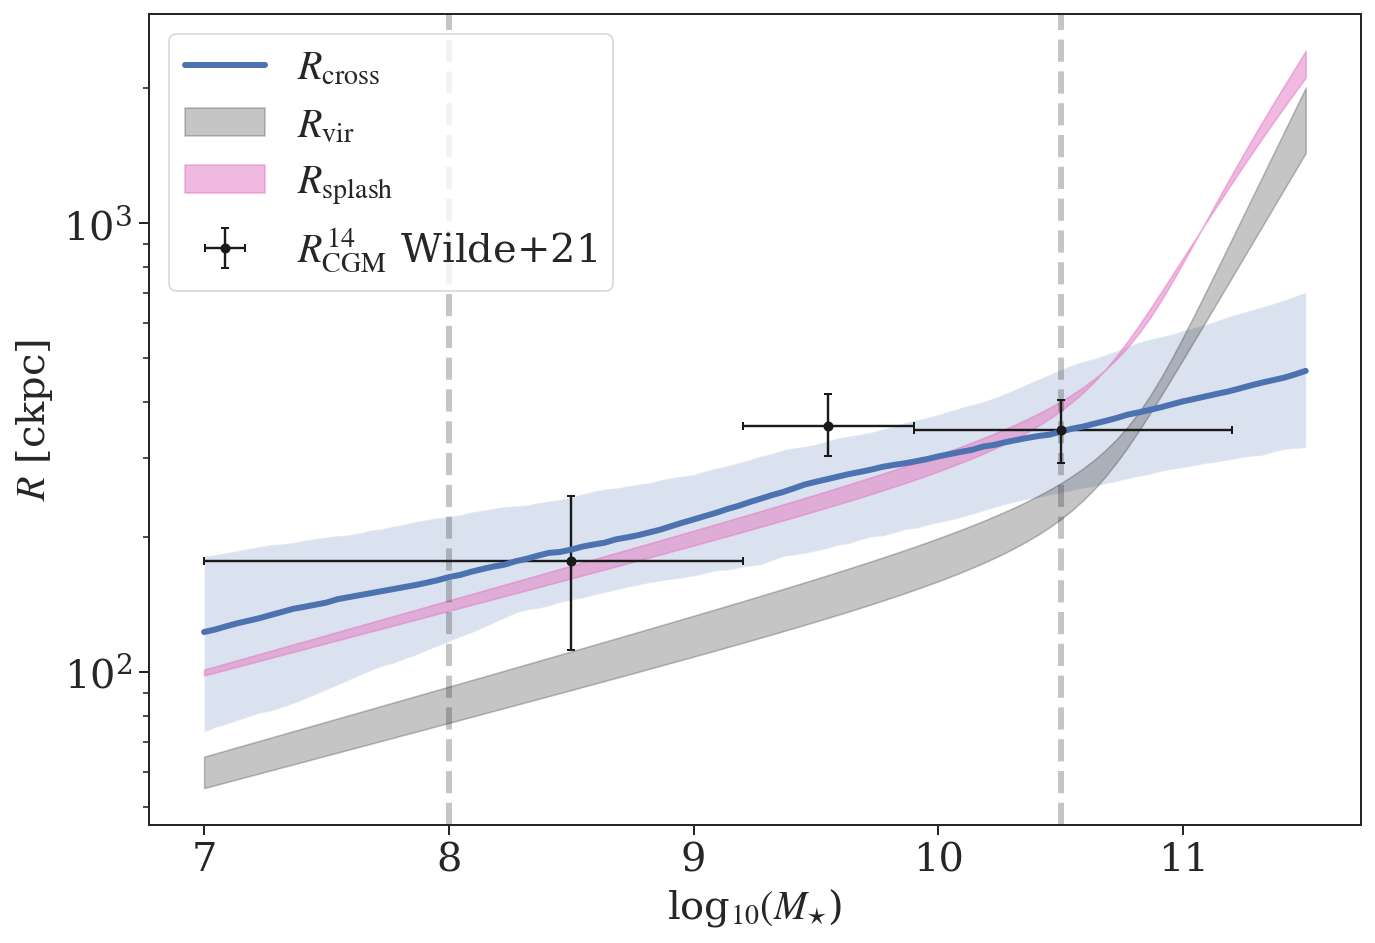

In [ ]:
import casbah.gal_properties as caprop
def calc_rvir(mass_space, redshift):
    """caclulate the virial radius of a halo in a given logmstar array and redshift

    Args:
        mass_space (_type_): _description_
        redshift (_type_): _description_

    Returns:
        _type_: _description_
    """
    logmhalo = [
            caprop.calchalomass(mstar, redshift)
            for mstar in mass_space]
    rvir = np.array([caprop.calcrvir(mh, redshift) for mh in logmhalo])
    return rvir


plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 20

flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)

rc = flat_samples[:, 4][::16]
beta = flat_samples[:, 5][::16]
mstars = df.mstars.values[:, None]
mass = np.geomspace(10**8, 10**10.5, 100)[:, None]
mass2 = np.geomspace(10**7, 10**11.5, 100)[:, None]
m0=10**9.5
z = df.z.values[:, None]

def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross

rc_m = r_cross_beta(rc, beta, mass, m0)
rc_m2 = r_cross_beta(rc, beta, mass2, m0)
# kirill: use np.quantile along the mass axis
med, lo, hi = np.quantile(rc_m*1e3, [0.5, 0.16, 0.84], axis=1)
med2, lo2, hi2 = np.quantile(rc_m2*1e3, [0.5, 0.16, 0.84], axis=1)


plt.figure(figsize=(10,7))
# plt.plot(np.log10(mass), rc_m*1000, alpha=0.02, c='xkcd:azure');

# fitting window
plt.axvline(x=8, color='k', linestyle='--', alpha=0.25, lw=3)
plt.axvline(x=10.5, color='k', linestyle='--', alpha=0.25, lw=3)



# rcross
plt.plot(np.log10(mass2), med2, alpha=1, label=r"$R_{\rm cross}}$", lw=3);
# plt.fill_between(np.log10(mass)[:,0], lo, hi, alpha=0.3)
plt.fill_between(np.log10(mass2)[:,0], lo2, hi2, alpha=0.2)

# r50 from paper I
# plt.fill_between(np.log10(m_lin)[:, 0], r50_lo[:, 0], r50_hi[:, 0], alpha=0.2)
# plt.plot(np.log10(m_lin)[:, 0], r50_med[:, 0], alpha=1, ls='--', label=r"$R_{\rm 50}$", lw=3, color="tab:red")
# plt.plot(np.log10(mass2), r50_med[:, 0], alpha=1, ls='--', label=r"$R_{\rm 50}$", lw=3, color="tab:red")

# r50 from paper I 2h
# plt.fill_between(np.log10(m_lin)[:, 0], r50_lo2h[:, 0], r50_hi2h[:, 0], alpha=0.2)
# plt.plot(np.log10(m_lin)[:, 0], r50_med2h[:, 0], alpha=1, ls='-.', label=r"$R_{\rm 50}^{2h}$")

# error bars from Paper I
xerror = [[1.5, (9.9 - 9.2)/2, (10.5 - 9.9)], [(9.2 - 8.5), 0.35, 0.7]] 

xlist = [8.5, 9.55, 10.5]
ylist = [177, 353, 346]
yerror = np.array([[65, 70], [50, 64], [53, 57]]).T
plt.errorbar(xlist, ylist, xerr=xerror, yerr=yerror, fmt='o', color='k', capsize=2, markersize=4, label=r"$R_{\rm CGM}^{14}$ Wilde+21")

# rvir - the correct 200c virial radius via colossus in comoving kpc. take care of h
m200c01 = np.squeeze(10**np.array([caprop.calchalomass(m, 0.1) for m in np.log10(mass2)]))
m200c04 = np.squeeze(10**np.array([caprop.calchalomass(m, 0.4) for m in np.log10(mass2)]))
R200c01 = mass_so.M_to_R(m200c01*cosmo.h, 0.1, '200c')/cosmo.h # proper kpc
R200c04 = mass_so.M_to_R(m200c04*cosmo.h, 0.4, '200c')/cosmo.h # proper kpc
plt.fill_between(np.log10(mass2)[:,0], R200c01*(1+0.1), R200c04*(1.4), alpha=0.25, label=r'$R_{\rm vir}$', color='k')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.fill_between(np.log10(mass2)[:,0], calc_splashback(mass2, 0.1, comoving=True), calc_splashback(mass2, 0.4, comoving=True), alpha=0.5, label=r'$R_{\rm splash}$', color='tab:pink')
plt.xlabel(r"log$_{10}(M_{\star}$)", fontsize=20)
plt.ylabel(r"$R$ [ckpc]", fontsize=20);
plt.yscale('log')
plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()
plt.savefig("../figures/r_cross_mstar.png", dpi=300)

In [ ]:
logmhalo

array([10.64984964, 11.26676212, 11.41159676, 11.50260229, 11.57118759,
       11.62749889, 11.67613303, 11.71957592, 11.75933159, 11.79638474,
       11.83141941, 11.86493347, 11.89730328, 11.92882235, 11.95972554,
       11.99020463, 12.02041865, 12.05050073, 12.08056259, 12.11069748,
       12.14098191, 12.17147663, 12.20222707, 12.23326347, 12.26460099,
       12.29623986, 12.328166  , 12.36035185, 12.3927579 , 12.42533462,
       12.45802473, 12.49076589, 12.52349324, 12.55614194, 12.58864941,
       12.62095702, 12.65301149, 12.68476567, 12.71617894, 12.74721729,
       12.77785304, 12.80806445, 12.83783519, 12.86715367, 12.89601249,
       12.9244078 , 12.95233874, 12.97980697, 13.00681614, 13.0333716 ])

In [ ]:
calc_splashback(mass2, 0.1, comoving=True)

array([  98.28543349,   99.77560273,  101.28834886,  102.82401874,
        104.38297175,  105.96557956,  107.57221786,  109.20326569,
        110.85910743,  112.54014567,  114.24679348,  115.97946901,
        117.7385952 ,  119.52460742,  121.33796276,  123.17912763,
        125.04857583,  126.94679   ,  128.87427749,  130.83156612,
        132.8191953 ,  134.83771606,  136.88770082,  138.96975655,
        141.08451003,  143.23260627,  145.41471253,  147.63154032,
        149.88383679,  152.1723775 ,  154.49796899,  156.86147007,
        159.26379812,  161.70591556,  164.18883272,  166.71362667,
        169.28146266,  171.89356662,  174.55123681,  177.25588032,
        180.00903352,  182.81234872,  185.66760027,  188.57670908,
        191.54178948,  194.56514261,  197.64926961,  200.79690965,
        204.01110357,  207.29519844,  210.65287839,  214.08823297,
        217.60584456,  221.21081673,  224.90884578,  228.70635484,
        232.61061534,  236.62984015,  240.77335441,  245.05185

### Rvir via `colossus`

# plot schematic

In [ ]:
def g1h(r, A, sigma):
    return A * np.exp(-r**2 / (2*sigma**2))

def xi2h(r, r0, gamma):
    return (r/r0)**-gamma

def _choose_rc(rc, A, r0, gamma):
    """ Choose which crossing to use.

    Args:
        rc (_type_): _description_
        A (_type_): _description_
        r0 (_type_): _description_
        gamma (_type_): _description_

    Returns:
        _type_: _description_
    """
    deriv = 2*np.log(A) + gamma*(2*np.log(rc/r0) - 1)
    if np.all(deriv > 0):
        return rc
    else:
        return None


def _calc_sig(rc, A, r0, gamma):
    r = _choose_rc(rc, A, r0, gamma)
    if r is None:
        return None
    else:
        sig = 0.5*r**2 / (np.log(A) + gamma*(np.log(r/r0)))
        return np.sqrt(sig)

def sigma_rc(rc, r0, A, gamma):
    return rc/np.sqrt(np.log(1/A)) - gamma*np.log(rc/r0)

0.10089268961755846


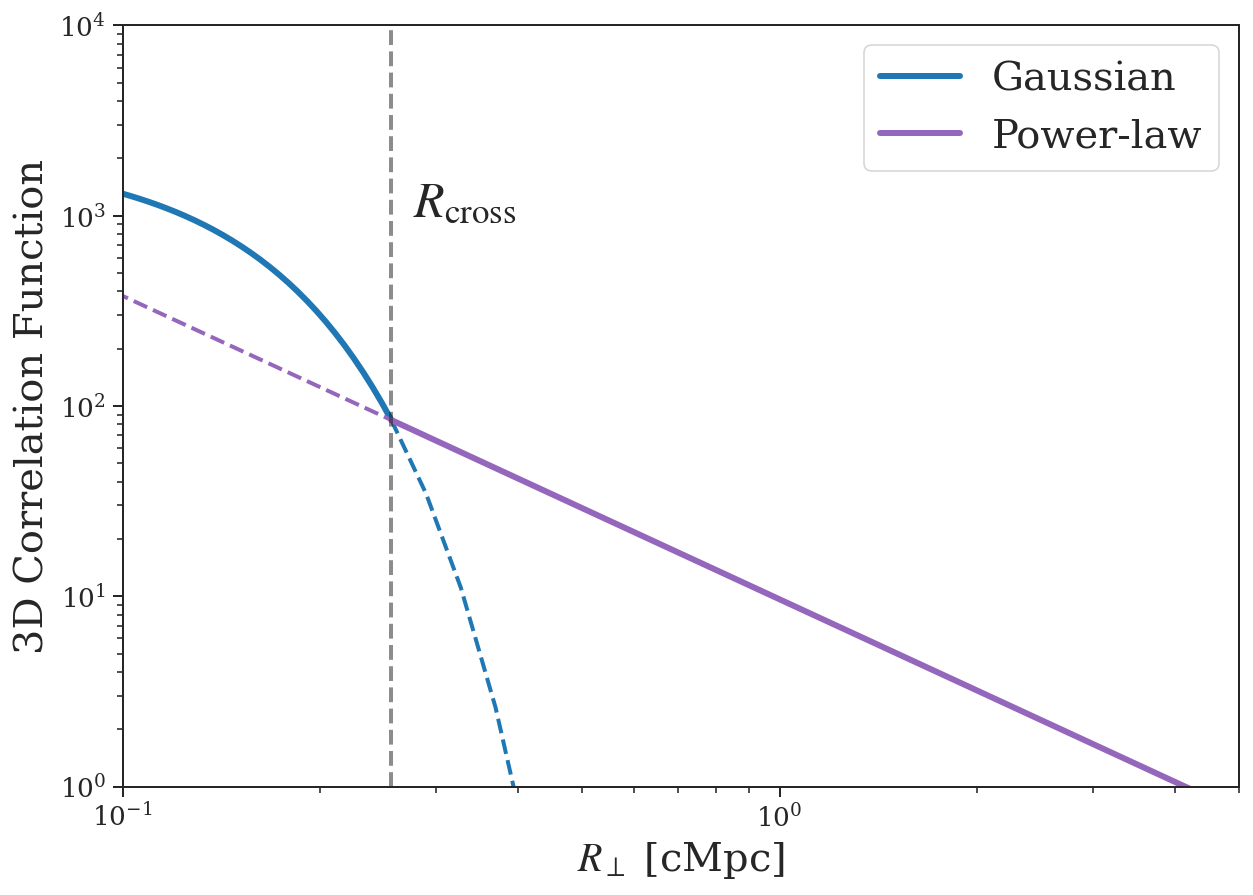

In [ ]:
import pickle

plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 25
pkl_file = '../exclusion-model/exclusion_model_gauss_1h_sampler.pkl'
infile = open(pkl_file, "rb")
sampler = pickle.load(infile)
infile.close()
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)

r0, gamma, beta2, A, r_cross, beta1, dndz_index, dndz_coeff = flat_samples[-55]
rlin_full = np.geomspace(0.01, 10, 100)
rlin_left = np.geomspace(0.01, r_cross, 100)
rlin_right = np.geomspace(r_cross, 100)


sig = _calc_sig(r_cross, A, r0, gamma)


labels = [r"$G(r)^{1h}$", r"$\xi(r)^{2h}$"]
labels = ["Gaussian", "Power-law"]
plt.figure(figsize=(10,7))
plt.plot(rlin_left, g1h(rlin_left, A, sig), label=labels[0], c='tab:blue', lw=3)
plt.plot(rlin_right, g1h(rlin_right, A, sig), c='tab:blue', lw=2, ls='--')
plt.plot(rlin_right, xi2h(rlin_right, r0, gamma), label=labels[1], c='tab:purple', lw=3)
plt.plot(rlin_left, xi2h(rlin_left, r0, gamma), c='tab:purple', lw=2, ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**0, 10**4)
plt.xlim(1e-1, 0.5e1)
plt.axvline(r_cross,  c="k", ls='--', alpha=0.5, lw=2)
plt.legend(fontsize=20)
# plt.ylabel(r"$\chi(r)$")
plt.ylabel("3D Correlation Function", fontsize=20)
plt.xlabel(r"$R_{\perp}$ [cMpc]",  fontsize=20)
plt.text(r_cross+0.02, 1e3, r"$R_{\rm cross}$")
plt.savefig('../figures/r_cross_schematic.pdf', dpi=300)
print(sig)

In [ ]:

df7.value_counts(df.survey)

survey
CASBaH     6136
CGM$^2$     453
dtype: int64

In [ ]:
6701 + 543, 6136 + 453

(7244, 6589)

In [ ]:
df.count()

Name            7244
z               7244
rho             7244
ang_sep         7244
RA              7244
DEC             7244
cosmo           7244
CreationDate    7244
user            7244
HM_0_500        7244
HM_0_100        7244
HM_100_200      7244
HM_200_300      7244
HM_300_400      7244
HM_400_500      7244
mstars          7244
rvir             543
rho_rvir         543
gal_type         543
z_igmsys        7244
log_rho         7244
Hz              7244
logm            7244
survey          7244
cf_model        7244
cf_model_2h     7244
dtype: int64

In [ ]:
df.z.min(), df.z.max()

(0.00310574308969, 0.480993837118148)

# X requests a plot

Can you generate a CDF figure of N_hits vs. R_perp?  Data and the 2 models.  This would effectively address item 1.  y-axis may need to be log-scale but maybe not.  x-axis probably should be.

NameError: name 'mass_bin_edges' is not defined

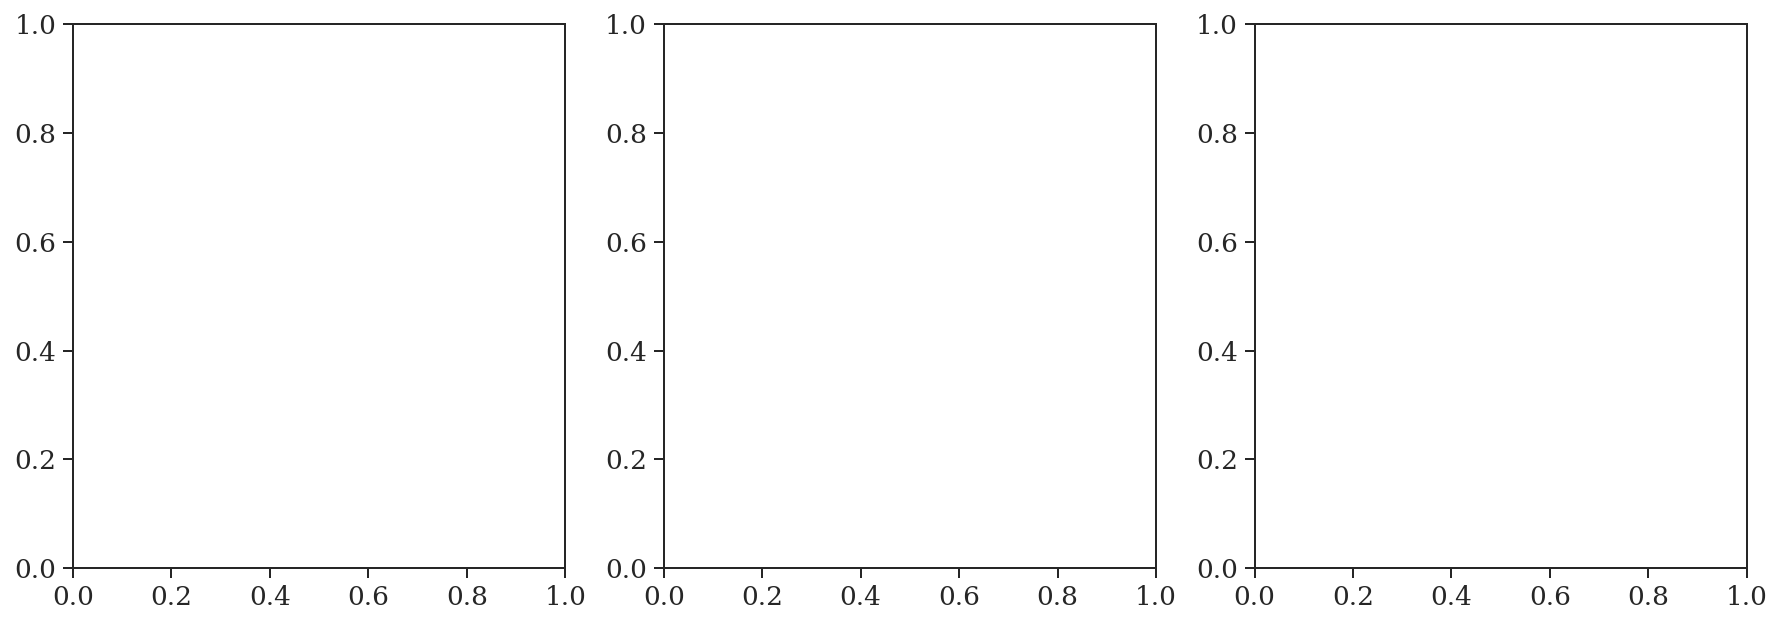

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
outcomes = df.HM_0_500.values
hits = (outcomes == "hit") 
for e, (low, high) in enumerate(zip(mass_bin_edges[:-1], mass_bin_edges[1:])):
    masscut = (10**low < mass) & (mass < 10**high)
    cut = hits & masscut

    axes[e].hist(rho_com[cut], bins=bins, cumulative=1, histtype='step', label='data');
    axes[e].hist(rho_com[masscut], bins=bins, cumulative=1, histtype='step', 
                weights=fc[masscut], label='model');

    if e == 0:
        axes[e].set_ylabel(r'$E[N_{abs}]$')

    text = f"{low} < logM*  < {high}"
    axes[e].text(0.2, 0.1, text, transform=axes[e].transAxes)
    axes[e].set_xlabel('R [cMpc]')
    if e == 1:
        axes[e].set_title(title)

plt.legend(bbox_to_anchor=(1, 0.99));

In [ ]:
def poissonerror(rho, fc, bins):
    # poisson error
    out = binned_statistic(rho, fc, statistic='sum', bins=bins)
    fmean = out[0]
    ferr = np.sqrt(fmean)
    return fmean, ferr

Rcross = 0.1928011782994607 [8, 9]
counts < 192.8011782994607]
[17] [16.70477292] [17.8460824]
[4.12310563] [4.08714728] [4.22446238]
poisson error
[17] [16.70477292] [20.79192021]
********************
Rcross = 0.2693491564661566 [9, 10]
counts < 269.3491564661566]
[43] [38.03630045] [41.59771196]
[6.55743852] [6.16735766] [6.44962882]
poisson error
[43] [38.03630045] [44.2036581]
********************
Rcross = 0.31954142725203494 [10, 10.5]
counts < 319.54142725203496]
[12] [12.40493894] [13.58111207]
[3.46410162] [3.52206458] [3.68525604]
poisson error
[12] [12.40493894] [15.92700352]
********************


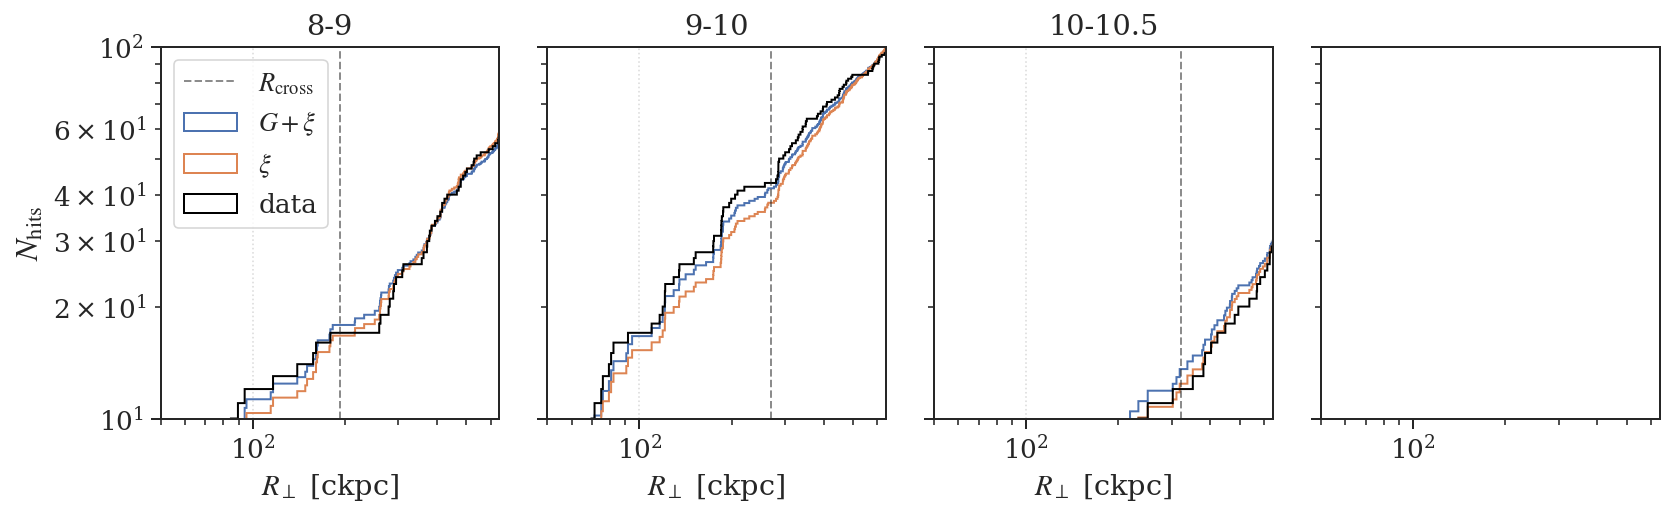

In [ ]:
# this is already done above
# df['cf_model'] = np.nanmean(sampler.blobs, axis=(0,1))
# df['cf_model_2h'] = np.nanmean(sampler_2h.blobs, axis=(0,1))

rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])
fig, axes = plt.subplots(1, 4, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

rc = flat_samples[:, 4][::16]
beta = flat_samples[:, 5][::16]
m0=10**9.5


def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross



rngs = [[8, 9], [9, 10], [10, 10.5]]

for e, (ax, rng) in enumerate(zip(axes, rngs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    # bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
    #                                             interval='jeffreys')

    # models
    #model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    #print(model[0])
    #model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    
    # ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='tab:pink', mew=2, ls='-', c='tab:pink', label=r'$\xi$')
    # ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='tab:purple', mew=2, ls='-', c='tab:purple', label=r'$G + \xi$')
    outcomes = ssdf.HM_0_500.values
    hits = (outcomes == "hit")
    fc_model = ssdf.cf_model.values
    fc_model2h = ssdf.cf_model_2h.values
    rho_com = ssdf.rho.values
    # rcross
    rc_m = r_cross_beta(rc, beta, 10**ssdf.logm.mean(), m0)
    med = np.median(rc_m)*1e3
    print(f"Rcross = {np.median(rc_m)}", rng)

    #rho_bins = [0, med, 1000, 10000, 20e3]
    #rho_bins = [0, med, 20e3]
    rho_bins = ssdf.rho.values
    
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model, label=r'$G + \xi$');
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model2h, label=r'$\xi$');    
    
    ax.hist(rho_com[hits], bins=rho_bins, cumulative=1, histtype='step', label='data', color='black', lw=1)
    ax.axvline(med, c="k", ls='--', alpha=0.5, lw=1, label=r'$R_{\rm cross}$')
    ax.set_title('{}-{}'.format(*rng))
    ax.set_xlabel(r"$R_{\perp}$ [ckpc]")
    ax.set_xlim(5e1, 2*med)
    ax.set_ylim(1e1, 1e2)
    ax.grid(ls=':', color='gainsboro')

    # calculate diff in prediction vs data below Rcross
    uplim = med
    bin = [0, uplim]
    datacount = np.histogram(rho_com[hits], bins=bin)
    modelcount = np.histogram(rho_com, bins=bin, weights=fc_model)
    model2hcount = np.histogram(rho_com, bins=bin, weights=fc_model2h)
    print(f"counts < {uplim}]")
    print(datacount[0], model2hcount[0],  modelcount[0])
    print(np.sqrt(datacount[0]), np.sqrt(model2hcount[0]), np.sqrt(modelcount[0]))
    # calculate poisson error
    # fdata, fdata_err = poissonerror(rho_com, fc_model, rho_bins)
    f1h, f1h_err = poissonerror(rho_com, fc_model, [0, uplim])
    f2h, f2h_err = poissonerror(rho_com, fc_model2h, [0, uplim])
    print("poisson error")
    # print(f1h, f2h, f1h_err, f2h_err)
    print(datacount[0], f2h, f2h+f2h_err)
    print("*"*20)

axes[0].legend()
plt.xscale('log')

if False:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    # plt.ylim(-0.05, 1.05)
    pass
# axes[1].set_xlabel('IP (ckpc)', fontsize=16)
axes[0].set_ylabel(r'$N_{\rm hits}$', fontsize=16);
plt.yscale('log')


plt.tight_layout();

In [ ]:
datacount = np.histogram(rho_com[hits], bins=[0, 301])
modelcount = np.histogram(rho_com, bins=[0, 301], weights=fc_model)
model2hcount = np.histogram(rho_com, bins=[0, 301], weights=fc_model2h)

In [ ]:
modelcount[0] - 1.96*np.sqrt(modelcount[0]), model2hcount[0] + 1.96*np.sqrt(model2hcount[0])


# correct bin
45.55474929 + 6.74942585

52.30417514

In [ ]:
df['cf_model_lo'] = np.nanquantile(sampler.blobs, 0.16, axis=(0,1))
df['cf_model_hi'] = np.nanquantile(sampler.blobs, 0.84, axis=(0,1))

NameError: name 'med' is not defined

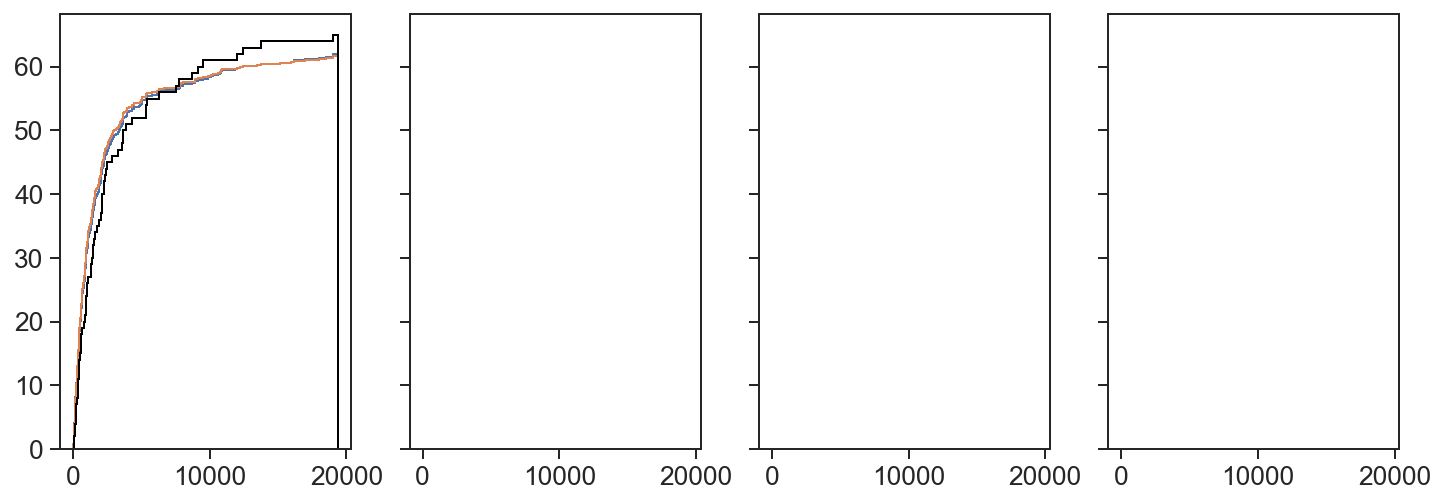

In [ ]:
# this is already done above
# df['cf_model'] = np.nanmean(sampler.blobs, axis=(0,1))
# df['cf_model_2h'] = np.nanmean(sampler_2h.blobs, axis=(0,1))



rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])
fig, axes = plt.subplots(1, 4, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

rc = flat_samples[:, 4][::16]
beta = flat_samples[:, 5][::16]
m0=10**9.5


def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross


if True:
    rngs = [[7, 8], [8, 9], [9, 10], [10, 11]]
else:
    rngs = [[8, 9], [9, 10], [10, 11]]

for e, (ax, rng) in enumerate(zip(axes, rngs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    # bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
    #                                             interval='jeffreys')

    # models
    #model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    #print(model[0])
    #model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    
    # ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='tab:pink', mew=2, ls='-', c='tab:pink', label=r'$\xi$')
    # ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='tab:purple', mew=2, ls='-', c='tab:purple', label=r'$G + \xi$')
    outcomes = ssdf.HM_0_500.values
    hits = (outcomes == "hit")
    fc_model = ssdf.cf_model.values
    fc_model2h = ssdf.cf_model_2h.values
    rho_com = ssdf.rho.values
    # rcross
    rc_m = r_cross_beta(rc, beta, 10**ssdf.logm.mean(), m0)

 


    #rho_bins = [0, med, 1000, 10000, 20e3]
    #rho_bins = [0, med, 20e3]
    rho_bins = ssdf.rho.values
    
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model, label=r'$G + \xi$');
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model2h, label=r'$\xi$'); 


    
    
    ax.hist(rho_com[hits], bins=rho_bins, cumulative=1, histtype='step', label='data', color='black', lw=1)
    ax.axvline(med, c="k", ls='--', alpha=0.5, lw=1, label=r'$R_{\rm cross}$')
    ax.set_title('{}-{}'.format(*rng))
    ax.set_xlabel(r"$R_{\perp}$ [ckpc]")
    log = False
    if log:
        # plt.yscale('log')
        # plt.xscale('log')
        ax.set_xlim(5e1, 2*med)
        ax.set_ylim(1e1, 1e2)
    else:
        ax.set_xlim(0, 2*med)
        ax.set_ylim(0, 100)
    ax.grid(ls=':', color='gainsboro')
axes[0].legend()


if False:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    # plt.ylim(-0.05, 1.05)
    pass
# axes[1].set_xlabel('IP (ckpc)', fontsize=16)
axes[0].set_ylabel(r'$N_{\rm hits}$', fontsize=16);
# plt.yscale('log')
# plt.xscale('log')


plt.tight_layout();

327.7966909839567


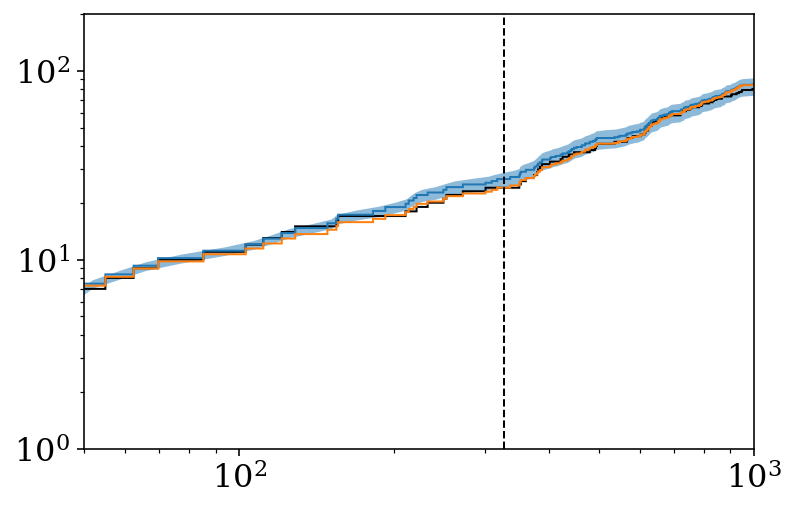

In [ ]:
# plt.fill_between(0.5*(rho_bins[1:] + rho_bins[:-1]), )   

#y_hi, binedges = np.histogram(rho_com, bins=rho_bins, weights=ssdf.cf_model_hi)
#y_med, b = np.histogram(rho_com, bins=rho_bins, weights=ssdf.cf_model)
h_hi, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_hi)
h_lo, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_lo)
dx = bin_edges[1] - bin_edges[0]
f_hi = np.cumsum(h_hi)*dx
f_lo = np.cumsum(h_lo)*dx
plt.fill_between(0.5*(rho_bins[1:] + rho_bins[:-1]), f_lo/17, f_hi/17, lw=2, label='cdf', alpha=0.5)
# y_lo, binedges = np.histogram(rho_com, bins=rho_bins, weights=ssdf.cf_model_lo)
# plt.fill_between(0.5*(rho_bins[1:] + rho_bins[:-1]), y_lo, y_hi, color='tab:blue', alpha=0.5)  
# plt.errorbar(0.5*(rho_bins[1:] + rho_bins[:-1]), y_med, yerr=[med-y_lo, y_hi-med], fmt='o', color='tab:blue', ms=5, lw=1, label='median')
plt.hist(rho_com[hits], bins=rho_bins, cumulative=1, histtype='step', lw=1, color='black', label='data')
plt.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
            weights=fc_model, label=r'$G + \xi$');
plt.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
            weights=fc_model2h, label=r'$\xi$');    
plt.axvline(med, c="k", ls='--', alpha=1, lw=1, label=r'$R_{\rm cross}$')
print(med)
plt.xlim(5e1, 1e3)
plt.ylim(1e0, 2e2)
plt.xscale('log')
plt.yscale('log')

<ipython-input-149-981aa930383c>:6: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [39.3679163423601 39.761816500011584 40.28796317851641 ...
 19710.920077724568 19807.2721230869 19944.14185569036] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(bin_edges[1:], f_lo, f_hi, 'r-', lw=2, label='cdf', alpha=0.25)


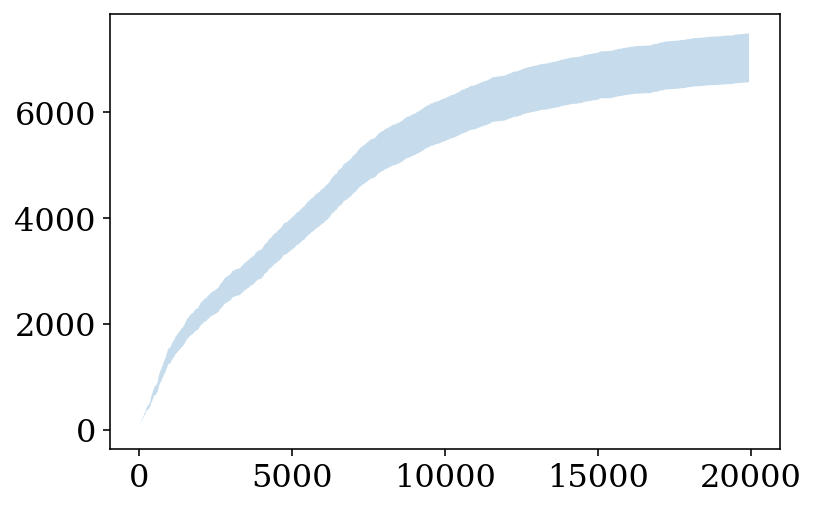

In [ ]:
h_hi, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_hi)
h_lo, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_lo)
dx = bin_edges[1] - bin_edges[0]
f_hi = np.cumsum(h_hi)*dx
f_lo = np.cumsum(h_lo)*dx
plt.fill_between(bin_edges[1:], f_lo, f_hi, 'r-', lw=2, label='cdf', alpha=0.25)

array([0.95033706, 0.90956724, 0.9506636 , ..., 0.17826954, 0.20382108,
       0.38614349])

In [ ]:
df

,Name,z,rho,ang_sep,RA,DEC,cosmo,CreationDate,user,HM_0_500,...,rvir,rho_rvir,gal_type,z_igmsys,log_rho,Hz,logm,survey,cf_model,cf_model_2h
0,J1553+3548_318_10,0.082712,16.619888,9.550870,238.268341,35.809929,Planck15,2021-Mar-15,mwilde,miss,...,130.879303,0.117270,SF,0.082555,1.220628,70.501571,8.841201,CGM$^2$,0.779171,0.872142
1,J1437+5045_206_41,0.018490,17.659946,41.247617,219.350861,50.755249,Planck15,2021-Mar-15,mwilde,miss,...,85.604588,0.202570,SF,0.018850,1.246989,68.328814,7.442364,CGM$^2$,0.652194,0.728770
2,J1133+0327_111_5,0.236701,22.505146,4.697760,173.367000,3.454861,Planck15,2021-Mar-15,mwilde,hit,...,523.891170,0.032816,E,0.237347,1.352282,76.503721,10.971467,CGM$^2$,0.950337,0.968900
3,J1241+5721_200_6,0.205262,26.595202,6.350156,190.474000,57.350389,Planck15,2021-Mar-15,mwilde,hit,...,183.087643,0.117362,SF,0.205592,1.424803,75.189212,9.906535,CGM$^2$,0.894498,0.916569
4,J1133+0327_105_6,0.236691,27.860515,5.815880,173.367340,3.454900,Planck15,2021-Mar-15,mwilde,hit,...,1076.360645,0.020930,SF+E,0.237347,1.444989,76.503294,11.283242,CGM$^2$,0.958533,0.964280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7387,J0235-0402_189_2356,0.438236,19807.272123,2356.020207,38.683218,-4.682089,Planck15,2021-Mar-28,jnburchett,miss,...,NaN,NaN,NaN,0.440730,4.296825,85.962183,10.713058,CASBaH,0.205076,0.189654
7388,J0751+2919_56_3394,0.293134,19838.578641,3393.559141,118.704501,29.848535,Planck15,2021-Mar-09,jnburchett,miss,...,NaN,NaN,NaN,0.294790,4.297511,78.974832,8.304075,CASBaH,0.169481,0.151260
7389,J1208+4540_184_3014,0.335515,19944.141856,3014.296823,182.162328,44.841086,Planck15,2021-Mar-28,jnburchett,hit,...,NaN,NaN,NaN,0.335860,4.299815,80.922923,10.529632,CASBaH,0.181068,0.165950
7390,J0751+2919_325_2204,0.477202,19961.539413,2203.667910,117.392278,29.825473,Planck15,2021-Mar-09,jnburchett,miss,...,NaN,NaN,NaN,0.475676,4.300194,87.987543,9.256881,CASBaH,0.211613,0.192601


AIC vs BIC

In [ ]:
model_2h._fields

('statistic', 'bin_edges', 'binnumber')

In [ ]:
model

BinnedStatisticResult(statistic=array([0.91880589, 0.8609598 , 0.71598107, 0.50057232, 0.40116564,
       0.31956772, 0.2366192 , 0.20098733, 0.1962494 , 0.19041789,
       0.1887211 ]), bin_edges=array([    0.        ,   100.        ,   169.86464646,   288.53998118,
         490.12741894,   832.5532074 ,  1414.21356237,  2402.24886796,
        4080.57154674,  6931.44843155, 11774.08037305, 20000.        ]), binnumber=array([ 1,  1,  1, ..., 11, 11, 11]))